<a href="https://colab.research.google.com/github/GARAM-SHIN/2025-1_CV/blob/main/HW%233.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lecture 3 : Deep Learning Vision**


## **[실험 A] 손실 함수 비교 : CrossEntropy Loss vs MSE Loss (with softmax)**


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [21]:
# GPU 사용 가능 여부 설정 : 가능할 시 GPU 사용, 불가능할 시 CPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
# Fashion-MNIST 데이터셋 로딩 및 전처리 : 정규화된 텐서 형태로 변환
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

In [23]:
# 데이터로더를 통해 학습 데이터와 테스트 데이터를 배치 단위로 불러오기
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [27]:
# 다층 퍼셉트론 MLP 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)   # 입력층 -> 은닉층1
        self.fc2 = nn.Linear(256, 128)    # 은닉층1 -> 은닉층2
        self.fc3 = nn.Linear(128, 10)    # 은닉층2 -> 출력층

    def forward(self, x, use_softmax=False):
        x = x.view(-1, 28*28)    # 입력 이미지를 1차원 벡터로 변환
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        if use_softmax:
            return F.softmax(x, dim=1)  # MSE Loss용
        return x  # CrossEntropy Loss용

In [34]:
# 손실 함수와 옵티마이저로 모델 학
def train(model, loss_fn, optimizer, use_softmax, epochs=20):
    model.train()    # 학습 모드로 모델 전환
    train_losses, test_losses, test_accuracies = [], [], []    # 손실 및 정확도 저장 리스트

    grad_distributions = {}  # gradient 저장용
    activation_distributions = {}  # activation 저장용

    for epoch in range(epochs):
        total_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()    # 이전 step의 gradient 초기화
            output = model(data, use_softmax)    # forward 연산

            # 학습 초기와 마지막 에포크의 활성화 분포 저장
            if epoch in [0, epochs-1]:
                activation_distributions[epoch] = {
                    'fc1': model.fc1(data.view(-1, 28*28)).detach().cpu(),    # fc1 전 활성화 값
                    'fc2': model.fc2(F.relu(model.fc1(data.view(-1, 28*28)))).detach().cpu()    # fc2 전 활성화 값
                }

            # MSE : one-hot 변환 후 softmax 출력 사용하여 손실 계산
            if isinstance(loss_fn, nn.MSELoss):
                target_one_hot = F.one_hot(target, num_classes=10).float()
                loss = loss_fn(output, target_one_hot)
            else:
                loss = loss_fn(output, target)
            loss.backward()    # 역전파 수행

            # 학습 초기와 마지막 에포크의 gradient 분포 저장
            if epoch in [0, epochs-1]:
                grads = []
                for param in model.parameters():
                    if param.grad is not None:
                        grads.append(param.grad.view(-1).detach().cpu())
                grad_distributions[epoch] = torch.cat(grads)

            optimizer.step()    # optimizer를 통한 가중치 갱
            total_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))    # 평균 손실 저장
        test_loss, acc = evaluate(model, loss_fn, use_softmax)    # 테스트 정확도 및 손실 측정
        test_losses.append(test_loss)
        test_accuracies.append(acc)
        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Test Acc = {acc:.2f}%")

    return train_losses, test_losses, test_accuracies, grad_distributions, activation_distributions    # 학습 손실, 테스트 손실, 정확도, gradient/activation 분포 반환

In [35]:
# 테스트 데이터에 대한 평가
@torch.no_grad()
def evaluate(model, loss_fn, use_softmax):
    model.eval()    # 모델을 평가 모드로 전환
    total_loss = 0    # 총 손실값
    correct = 0    # 정확하게 분류한 샘플 수
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data, use_softmax)    # 모델 예측 수행
        if isinstance(loss_fn, nn.MSELoss):    # 손실 계산 방식은 손실 함수 종류에 따라 다름
            target_one_hot = F.one_hot(target, num_classes=10).float()    # MSE : one-hot 인코딩하여 softmax 출력과 비교
            loss = loss_fn(output, target_one_hot)
            pred = output.argmax(dim=1)    # 예측 클래스 = 최대값의 인덱스
        else:
            loss = loss_fn(output, target)    # CrossEntropy : 내부적으로 softmax를 포함
            pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()    # 정확히 예측한 샘플 수 카운트
        total_loss += loss.item()
    return total_loss / len(test_loader), 100. * correct / len(test_loader.dataset)    # 평균 손실과  전체 정확도 반환

In [36]:
# CrossEntropy 실행
model_ce = MLP().to(device)    # 모델 인스턴스 생성
optimizer_ce = optim.Adam(model_ce.parameters(), lr=0.001)    # 옵티마이저와 학습률  설정
loss_ce = nn.CrossEntropyLoss()    # 손실 함수 적용
train_ce, test_ce, acc_ce, grads_ce, acts_ce = train(model_ce, loss_ce, optimizer_ce, use_softmax=False)    # 학습 실행

Epoch 1: Train Loss = 0.5292, Test Acc = 83.56%
Epoch 2: Train Loss = 0.3708, Test Acc = 85.45%
Epoch 3: Train Loss = 0.3366, Test Acc = 86.83%
Epoch 4: Train Loss = 0.3101, Test Acc = 87.19%
Epoch 5: Train Loss = 0.2906, Test Acc = 87.03%
Epoch 6: Train Loss = 0.2750, Test Acc = 87.49%
Epoch 7: Train Loss = 0.2605, Test Acc = 88.52%
Epoch 8: Train Loss = 0.2490, Test Acc = 88.98%
Epoch 9: Train Loss = 0.2361, Test Acc = 88.22%
Epoch 10: Train Loss = 0.2289, Test Acc = 87.84%
Epoch 11: Train Loss = 0.2189, Test Acc = 88.83%
Epoch 12: Train Loss = 0.2129, Test Acc = 88.56%
Epoch 13: Train Loss = 0.2018, Test Acc = 89.22%
Epoch 14: Train Loss = 0.1955, Test Acc = 88.66%
Epoch 15: Train Loss = 0.1867, Test Acc = 88.51%
Epoch 16: Train Loss = 0.1807, Test Acc = 89.15%
Epoch 17: Train Loss = 0.1736, Test Acc = 89.34%
Epoch 18: Train Loss = 0.1664, Test Acc = 88.72%
Epoch 19: Train Loss = 0.1630, Test Acc = 89.05%
Epoch 20: Train Loss = 0.1562, Test Acc = 89.27%


In [37]:
# MSE 실행
model_mse = MLP().to(device)    # 모델 인스턴스 생성
optimizer_mse = optim.Adam(model_mse.parameters(), lr=0.001)    # 옵티마이저 및 학습률 설저
loss_mse = nn.MSELoss()    # 손실 함수 적용
train_mse, test_mse, acc_mse, grad_mse, acts_mse = train(model_mse, loss_mse, optimizer_mse, use_softmax=True)    # 함수 실행

Epoch 1: Train Loss = 0.0271, Test Acc = 84.51%
Epoch 2: Train Loss = 0.0198, Test Acc = 85.04%
Epoch 3: Train Loss = 0.0181, Test Acc = 84.84%
Epoch 4: Train Loss = 0.0170, Test Acc = 86.67%
Epoch 5: Train Loss = 0.0161, Test Acc = 86.96%
Epoch 6: Train Loss = 0.0155, Test Acc = 87.70%
Epoch 7: Train Loss = 0.0148, Test Acc = 87.50%
Epoch 8: Train Loss = 0.0143, Test Acc = 88.34%
Epoch 9: Train Loss = 0.0137, Test Acc = 88.40%
Epoch 10: Train Loss = 0.0134, Test Acc = 88.40%
Epoch 11: Train Loss = 0.0130, Test Acc = 88.60%
Epoch 12: Train Loss = 0.0125, Test Acc = 88.93%
Epoch 13: Train Loss = 0.0122, Test Acc = 88.08%
Epoch 14: Train Loss = 0.0118, Test Acc = 88.74%
Epoch 15: Train Loss = 0.0116, Test Acc = 89.18%
Epoch 16: Train Loss = 0.0111, Test Acc = 88.38%
Epoch 17: Train Loss = 0.0110, Test Acc = 88.39%
Epoch 18: Train Loss = 0.0107, Test Acc = 88.97%
Epoch 19: Train Loss = 0.0104, Test Acc = 89.01%
Epoch 20: Train Loss = 0.0100, Test Acc = 89.25%


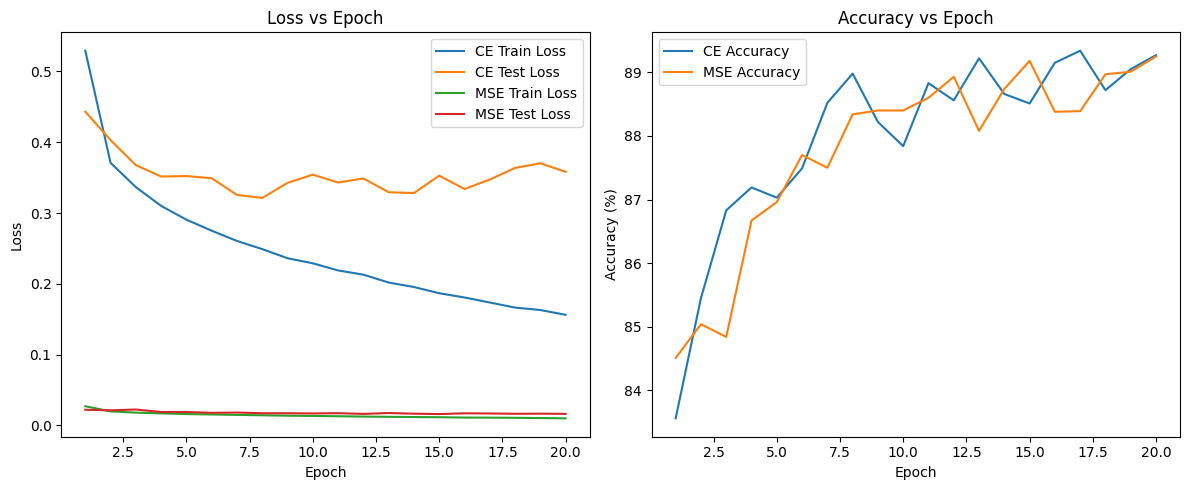

In [38]:
epochs = range(1, len(train_ce) + 1)    # 에포크 범위 정의
plt.figure(figsize=(12, 5))    # 전체 플롯 크기 설정

# Loss vs Epoch 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_ce, label='CE Train Loss')
plt.plot(epochs, test_ce, label='CE Test Loss')
plt.plot(epochs, train_mse, label='MSE Train Loss')
plt.plot(epochs, test_mse, label='MSE Test Loss')
plt.xlabel("Epoch")    # x축
plt.ylabel("Loss")    # y축
plt.title("Loss vs Epoch")
plt.legend()

# Accuracy vs Epoch 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_ce, label='CE Accuracy')
plt.plot(epochs, acc_mse, label='MSE Accuracy')
plt.xlabel("Epoch")    # x축
plt.ylabel("Accuracy (%)")    # y축
plt.title("Accuracy vs Epoch")
plt.legend()

plt.tight_layout()
plt.show()    # 시각화 결과 출력

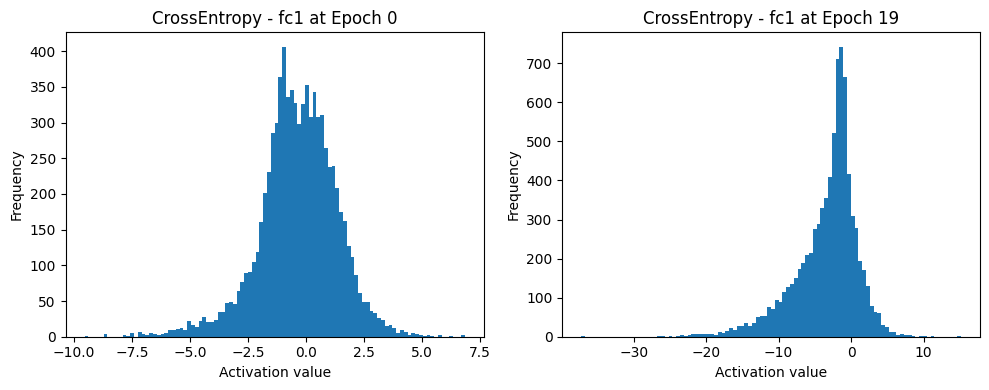

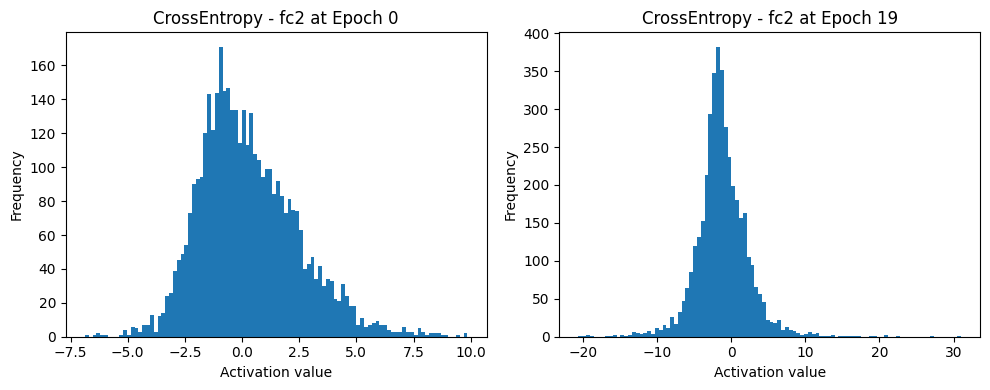

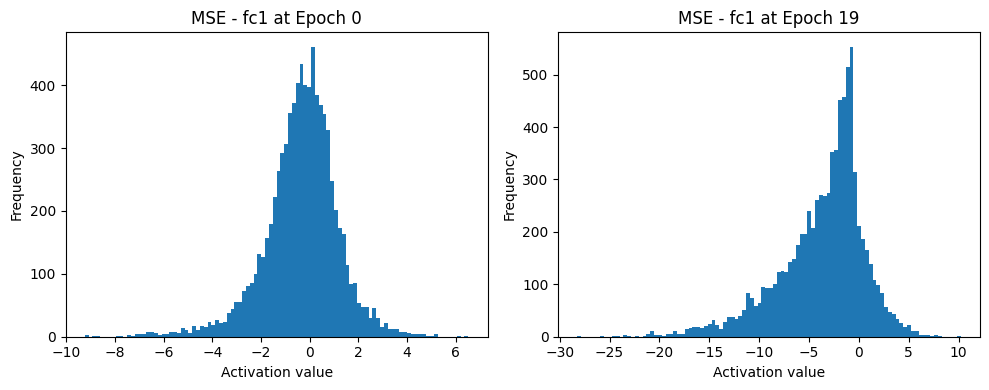

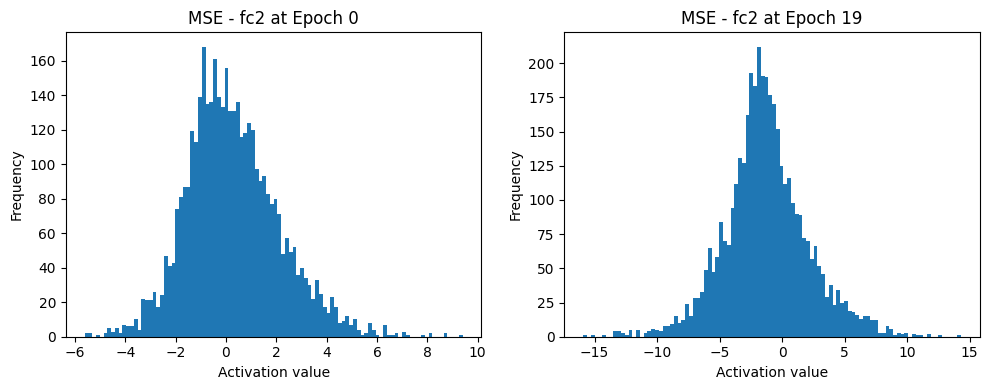

In [42]:
# Layer의 활성화 값 분포를 에포크별로 시각화
def plot_activation_distribution(acts_dict, layer_name, title=""):
    plt.figure(figsize=(10, 4))
    for i, epoch in enumerate(acts_dict.keys()):
        plt.subplot(1, 2, i+1)
        plt.hist(acts_dict[epoch][layer_name].flatten().numpy(), bins=100)    # 활성화 텐서를 1차원 배열로 평탄화한 후 히스토그램 생성
        plt.title(f"{title} - {layer_name} at Epoch {epoch}")
        plt.xlabel("Activation value")    # x축
        plt.ylabel("Frequency")    # y축
    plt.tight_layout()
    plt.show()    # 시각화 결과 출력

# CrossEntropy 모델의 은닉층 활성화 분포 시각화
plot_activation_distribution(acts_ce, 'fc1', "CrossEntropy")    # 첫 번째 은닉층
plot_activation_distribution(acts_ce, 'fc2', "CrossEntropy")    # 두 번째 은닉층

# MSE 모델의 은닉층 활성화 분포 시각화
plot_activation_distribution(acts_mse, 'fc1', "MSE")    # 첫 번째 은닉층
plot_activation_distribution(acts_mse, 'fc2', "MSE")    # 두 번째 은닉층

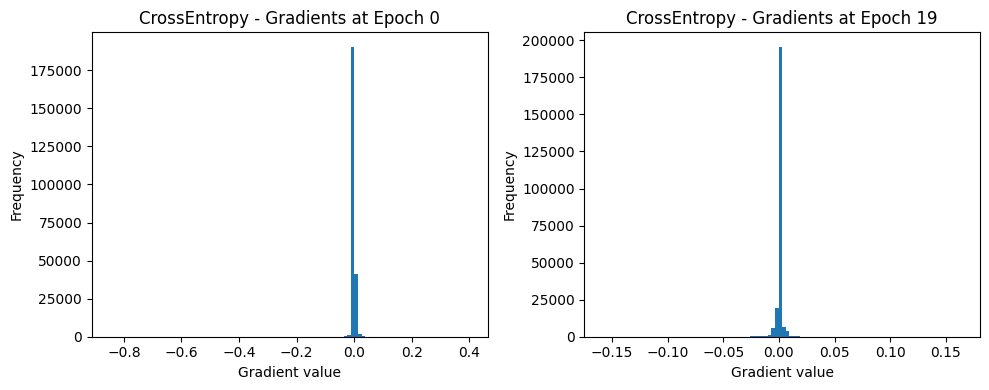

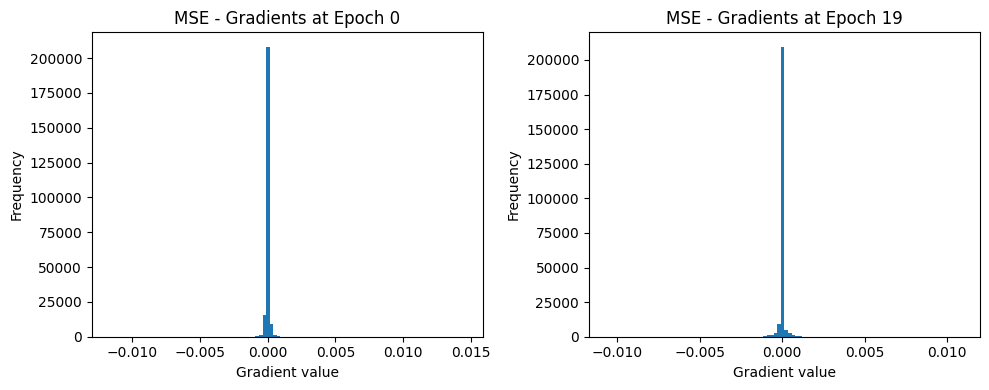

In [44]:
# 에포크별 그레디언트 분포 시각화
def plot_gradient_distribution(grads_dict, title=""):
    plt.figure(figsize=(10, 4))
    for i, epoch in enumerate(grads_dict.keys()):
        plt.subplot(1, 2, i+1)
        plt.hist(grads_dict[epoch].numpy(), bins=100)    # 해당 에포크의 그레디언트를 1차원 배열로 평탄화한 후 히스토그램 생성
        plt.title(f"{title} - Gradients at Epoch {epoch}")
        plt.xlabel("Gradient value")
        plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()    # 시각화 결과 출력

# CrossEntropy 모델의 그레디언트 분포 시각화
plot_gradient_distribution(grads_ce, "CrossEntropy")

# MSE 모델의 그레디언트 분포 시각화
plot_gradient_distribution(grad_mse, "MSE")

## **[실험 B] 활성화 함수 비교 : ReLU vs LeakyReLU vs Sigmoid**

In [111]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [112]:
# GPU 사용 가능 여부 설정 : 가능할 시 GPU 사용, 불가능할 시 CPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [113]:
# 비선형 2차원 분류 무넺를 위한 데이터셋 생성 및 전처리
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)    # make_moons 데이터셋 사용
X = StandardScaler().fit_transform(X)    # 정규화
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)    # 학습 데이터와 데스트 데이터 분할

In [114]:
# 학습 및 테스트 데이터를 PyTorch Tensor로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

In [115]:
# 다층 퍼셉트론 MLP 정의
class MLP(nn.Module):
    def __init__(self, activation_fn):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 16)    # 입력층 -> 은닉층1
        self.fc2 = nn.Linear(16, 16)    # 은닉층1 -> 은닉층2
        self.fc3 = nn.Linear(16, 2)    # 은닉층2 -> 출력층
        self.act1 = activation_fn()    # 활성화 함수 지정
        self.act2 = activation_fn()
        self.activations = []    # 은닉층 출력값을 저장할 리스트

    def forward(self, x):
        x = self.fc1(x)    # 첫 번째 은닉층 연산
        a1 = self.act1(x)
        self.activations.append(a1.detach().cpu())  # 중간 출력 저장

        x = self.fc2(a1)    # 두 번째 은닉층 연산
        a2 = self.act2(x)
        self.activations.append(a2.detach().cpu())    # 출력 저장

        x = self.fc3(a2)    # 출력층 연산
        return x

In [116]:
# 활성화 함수로 MLP 학습
def train_model(activation_fn, epochs=500):
    model = MLP(activation_fn).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    model.activations = []    # 중간 출력 저장
    loss_list = []
    acc_list = []

    for epoch in range(epochs):    # 에포크 수만큼 학습 반복
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())

        with torch.no_grad():    # 테스트 정확도 계산
            model.eval()
            pred = model(X_test_tensor).argmax(dim=1)
            acc = (pred == y_test_tensor).float().mean().item()
            acc_list.append(acc * 100)

        if epoch % 100 == 0:    # 에포크 100마다 학습 진행 상황 출력
            print(f"{activation_fn.__name__} Epoch {epoch}, Loss: {loss.item():.4f}, Acc: {acc:.2f}%")

    return model, loss_list, acc_list

In [117]:
model_relu, loss_relu, acc_relu = train_model(nn.ReLU)    # ReLU 활성화 함수

ReLU Epoch 0, Loss: 0.6982, Acc: 0.76%
ReLU Epoch 100, Loss: 0.0762, Acc: 0.98%
ReLU Epoch 200, Loss: 0.0612, Acc: 0.99%
ReLU Epoch 300, Loss: 0.0565, Acc: 0.99%
ReLU Epoch 400, Loss: 0.0548, Acc: 0.99%


In [118]:
model_leaky, loss_leaky, acc_leaky = train_model(nn.LeakyReLU)    # LeakyReLU 활성화 함수

LeakyReLU Epoch 0, Loss: 0.7147, Acc: 0.72%
LeakyReLU Epoch 100, Loss: 0.0755, Acc: 0.97%
LeakyReLU Epoch 200, Loss: 0.0615, Acc: 0.99%
LeakyReLU Epoch 300, Loss: 0.0590, Acc: 0.99%
LeakyReLU Epoch 400, Loss: 0.0569, Acc: 0.99%


In [119]:
model_sigmoid, loss_sigmoid, acc_sigmoid = train_model(nn.Sigmoid)    # Sigmoid 활성화 함수

Sigmoid Epoch 0, Loss: 0.7954, Acc: 0.50%
Sigmoid Epoch 100, Loss: 0.2986, Acc: 0.87%
Sigmoid Epoch 200, Loss: 0.2886, Acc: 0.87%
Sigmoid Epoch 300, Loss: 0.1352, Acc: 0.97%
Sigmoid Epoch 400, Loss: 0.0836, Acc: 0.99%


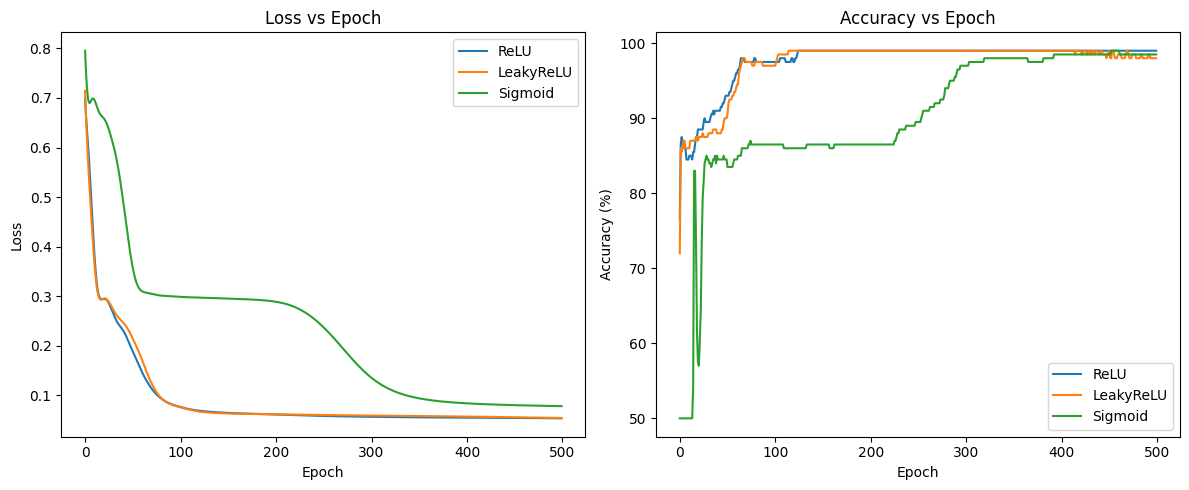

In [120]:
# 손실 및 정확도 시각화
epochs = range(500)
plt.figure(figsize=(12, 5))

# 손실 곡선 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_relu, label="ReLU")
plt.plot(epochs, loss_leaky, label="LeakyReLU")
plt.plot(epochs, loss_sigmoid, label="Sigmoid")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()

# 정확도 곡선 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_relu, label="ReLU")
plt.plot(epochs, acc_leaky, label="LeakyReLU")
plt.plot(epochs, acc_sigmoid, label="Sigmoid")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epoch")
plt.legend()

plt.tight_layout()
plt.show()    # 시각화 결과 출력

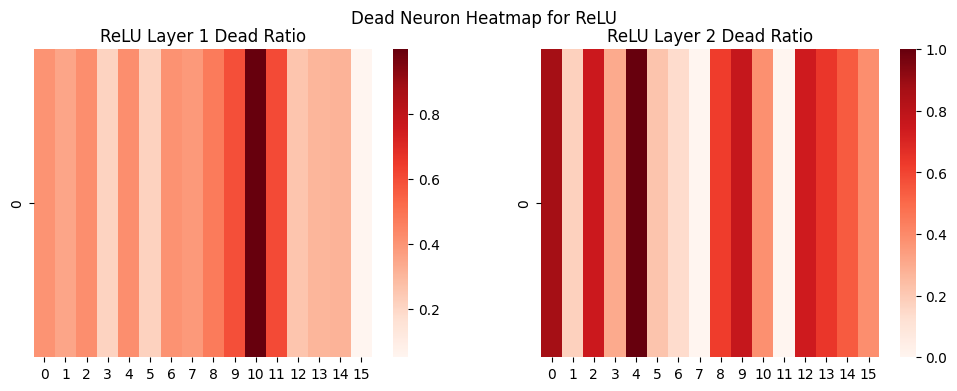

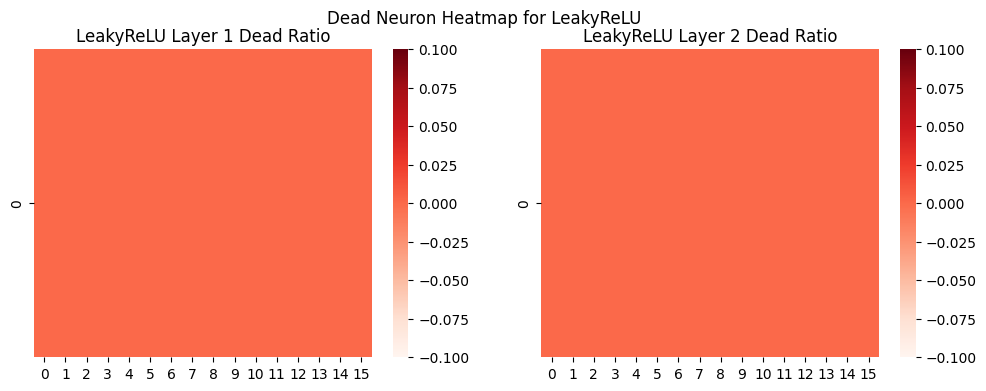

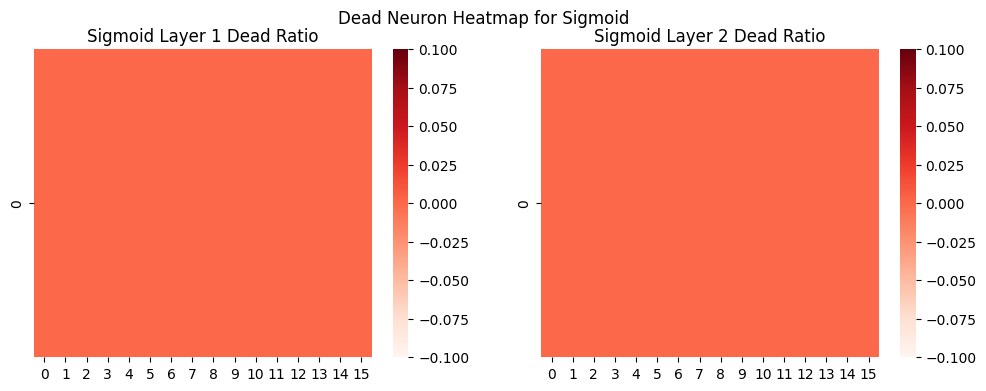

In [121]:
# Layer에서 dead neuron 비율을 히트맵으로 시각화
def plot_dead_neurons(model, title):
    layer_activations = model.activations    # 은닉층 활성화 값 리스트
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    for i, act in enumerate(layer_activations[:2]):
        dead = (act == 0).float().mean(dim=0)    # dead neuron 비율 계산
        sns.heatmap(dead.unsqueeze(0), cmap='Reds', cbar=True, ax=axes[i])    # 히트맵 시각화
        axes[i].set_title(f"{title} Layer {i+1} Dead Ratio")

    plt.suptitle(f"Dead Neuron Heatmap for {title}")
    plt.show()


# 각 활성화 함수 모델에 대해 dead neuron 시각화 실행
plot_dead_neurons(model_relu, "ReLU")
plot_dead_neurons(model_leaky, "LeakyReLU")
plot_dead_neurons(model_sigmoid, "Sigmoid")

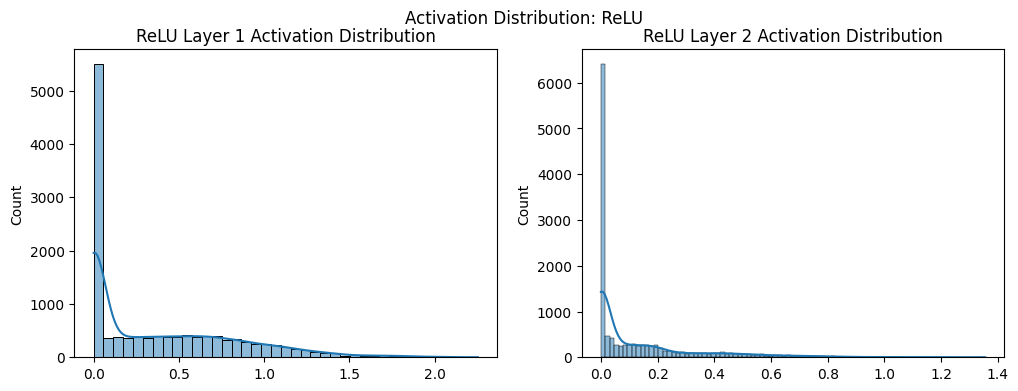

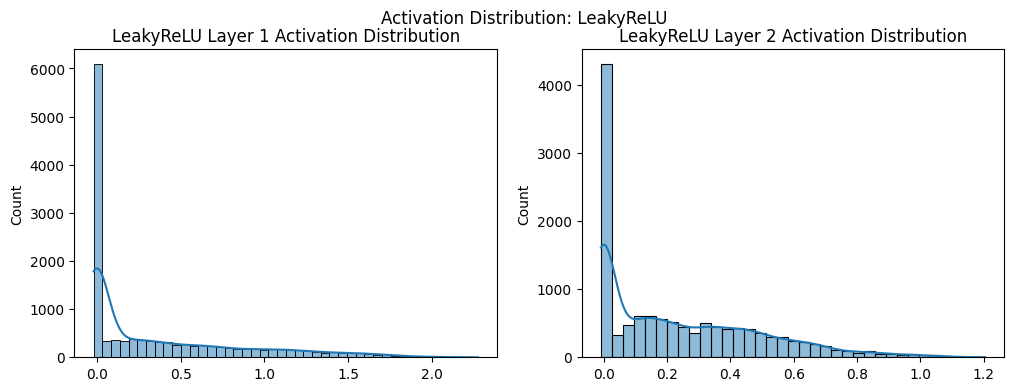

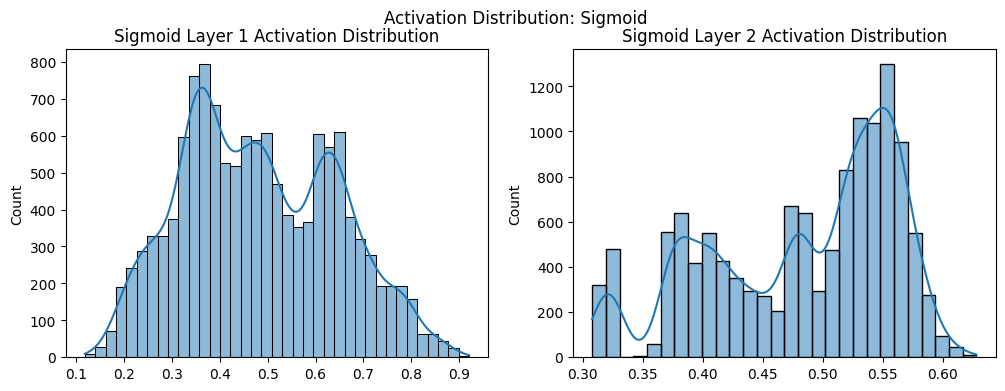

In [122]:
# Layer의 활성화 값 분포를 히스토그램과 곡선 그래프로 시각화
def plot_activation_distribution(model, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    for i in range(2):
        sns.histplot(model.activations[i].flatten(), kde=True, ax=axes[i])
        axes[i].set_title(f"{title} Layer {i+1} Activation Distribution")
    plt.suptitle(f"Activation Distribution: {title}")
    plt.show()

# 각 활성화 함수에 대해 시각화 결과 출력
plot_activation_distribution(model_relu, "ReLU")
plot_activation_distribution(model_leaky, "LeakyReLU")
plot_activation_distribution(model_sigmoid, "Sigmoid")

In [123]:
# Layer의 활성화 텐서에서 dead ReLU 비율 계산
def calculate_dead_relu_ratio(activation_tensor):
    is_dead = (activation_tensor == 0).float().mean(dim=0) == 1.0    # 각 뉴런이 전체 샘플에 대해 0인지 여부를 계산 후 평균값이 1.0일 경우 완전히 죽은 뉴런으로 판별
    return round(is_dead.sum().item() / activation_tensor.shape[1] * 100, 2)    # 죽은 뉴런 수 / 전체 뉴런 수 * 100

In [124]:
# 정확도 리스트를 기반으로 수렴한 에포크를 추정
# 연속된 3개 에포크의 정확도 변환폭이 임계값보다 작을 경우 수렴 시점으로 판정
def estimate_convergence_epoch(acc_list, threshold=0.3):
    for i in range(3, len(acc_list)):    # 최근 3개 에포크의 정확도 변화폭 확인
        if max(acc_list[i-3:i]) - min(acc_list[i-3:i]) < threshold:
            return i    # 수렴한 시점 반환
    return len(acc_list)    # 수렴하지 않으면 마지막 에포크 반환

In [125]:
# 모델의 Dead ReLU의 비율과 수렴 시점을 계산하여 딕셔너리 형태로 반환
def analyze_model(model, acc_list, name):
    dead1 = calculate_dead_relu_ratio(model.activations[0])    # 각 은닉층에서의 dead neuron 비율 계산
    dead2 = calculate_dead_relu_ratio(model.activations[1])
    avg_dead = round((dead1 + dead2) / 2, 2)    # 평균 dead 비율
    conv_epoch = estimate_convergence_epoch(acc_list)    # 수렴 시점 추정

    # 결과 딕셔너리 반환
    return {
        "Activation": name,
        "Dead ReLU Layer 1 (%)": dead1,
        "Dead ReLU Layer 2 (%)": dead2,
        "Avg Dead ReLU (%)": avg_dead,
        "Convergence Epoch": conv_epoch
    }

In [126]:
import pandas as pd

# 각 모델에 대해 Dead ReLU 비율 및 수렴 시점 분석
relu_analysis = analyze_model(model_relu, acc_relu, "ReLU")
leaky_analysis = analyze_model(model_leaky, acc_leaky, "LeakyReLU")
sigmoid_analysis = analyze_model(model_sigmoid, acc_sigmoid, "Sigmoid")

# 분석 결과를 표 형태로 정리
results_df = pd.DataFrame([relu_analysis, leaky_analysis, sigmoid_analysis])
print(results_df)    # 결과 출력

  Activation  Dead ReLU Layer 1 (%)  Dead ReLU Layer 2 (%)  Avg Dead ReLU (%)  \
0       ReLU                    0.0                   6.25               3.12   
1  LeakyReLU                    0.0                   0.00               0.00   
2    Sigmoid                    0.0                   0.00               0.00   

   Convergence Epoch  
0                 10  
1                  9  
2                  3  


## **[실험 C] 최적화 알고리즘 비교 : SGD, SGD+Momentum, Adam**

In [195]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [196]:
# GPU 사용 가능 여부 설정 : 가능할 시 GPU 사용, 불가능할 시 CPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [197]:
# Fashion-MNIST 데이터셋 로딩 및 전처리 : 정규화된 텐서 형태로 변환
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [198]:
# 데이터로더를 통해 학습 데이터와 테스트 데이터를 배치 단위로 불러오기
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [199]:
# 다층 퍼셉트론 MLP 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)    # 입력층 -> 은닉층1
        self.fc2 = nn.Linear(256, 128)    # 은닉층1 -> 은닉층2
        self.fc3 = nn.Linear(128, 10)    # 은닉층2 -> 출력층
        self.a1 = None    # 각 은닉층의 활성화 값을 저장
        self.a2 = None

    def forward(self, x):
        x = x.view(-1, 28*28)    # 이미지 평탄화
        x1 = self.fc1(x)
        a1 = F.relu(x1)
        x2 = self.fc2(a1)
        a2 = F.relu(x2)
        self.a1 = a1.detach().cpu()    # 활성화 분포 저장
        self.a2 = a2.detach().cpu()
        return self.fc3(a2)    # softmax는 손실 함수에서 처

In [200]:
# 모델 정확도 계산
@torch.no_grad()    # 그레디언트 계산 비활성화
def evaluate(model):
    model.eval()    # 평가 모드로 전환
    correct = 0    # 정확히 예측한 샘플 수
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)    # 모델 예측
        pred = output.argmax(dim=1)    # 가장 확률 높은 값의 인덱스를 예측 클래스로
        correct += pred.eq(target).sum().item()    # 정답과 비교하여 정확히 예측한 수 누적
    return 100. * correct / len(test_loader.dataset)    # 전체 정확도 반환

In [201]:
results = {}    # 실행 결과를 저장할 딕셔너리 초기화

In [202]:
# Optimizer로 MLP 학습하고 손실 및 정확도 결과 반환
def train_optimizer(optimizer_type="SGD", lr=0.01, use_scheduler=False, epochs=30):
    model = MLP().to(device)    # 모델 정의
    criterion = nn.CrossEntropyLoss()    # 손실 함수 : CrossEntropy

    # Optimizer 선택
    if optimizer_type == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_type == "SGD+Momentum":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_type == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)

    # 지수적 학습률 감소 스케줄러
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) if use_scheduler else None
    losses = []    # 에포크별 학습 손실 저장
    accs = []    # 에포크별 테스트 정확도 저장

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        # 미니배치 학습
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # 학습률 감소 스케줄러 적용
        if scheduler:
            scheduler.step()

        # 평가 및 기록
        acc = evaluate(model)
        losses.append(total_loss / len(train_loader))
        accs.append(acc)

        if epoch % 5 == 0:
            print(f"{optimizer_type} (lr={lr}) Epoch {epoch}, Loss={losses[-1]:.4f}, Acc={acc:.2f}%")

    return model, losses, accs    # 학습된 모델, 손실 리스트, 정확도 리스트 반환

In [203]:
# 정확도 리스트에서 수렴 시점 추정
def estimate_convergence_epoch(acc_list, threshold=0.3):    # 최근 3개 에포크 정확도 변화가 임계값보다 작을 경우 수렴 시점으로 판단
    for i in range(3, len(acc_list)):
        if max(acc_list[i-3:i]) - min(acc_list[i-3:i]) < threshold:
            return i    # 수렴한 시점 반환
    return len(acc_list)    # 끝까지 수렴하지 않았으면 전체 에포크 수 반환

In [204]:
# 학습 정확도의 안정성 측정
def measure_accuracy_stability(acc_list, after=20):
    stable_accs = acc_list[after:]    # 학습 후반부의 정확도만 추출
    return round(np.var(stable_accs), 4)

In [207]:
activation_snapshots = {}    # 학습 도중 특정 시점에서의 활성화 값 분포를 저장할 딕셔너리

In [208]:
# Optimizer로 모델을 학습하고 지정한 에포크에서 활성화 값을 스냅샷으로 저장
def train_with_activation_snapshots(optimizer_type="Adam", lr=0.001, snapshot_epochs=[0, 10, 29], epochs=30):
    model = MLP().to(device)    # 모델 생성
    criterion = nn.CrossEntropyLoss()    # 손실 함수 정의

    # Optimizer 선택
    if optimizer_type == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_type == "SGD+Momentum":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_type == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):    # 에포크 수만큼 반복
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            break

        # 지정된 에포크에 대해 활성화 스냅샷 저장
        if epoch in snapshot_epochs:
            activation_snapshots[(optimizer_type, lr, epoch)] = (model.a1.clone(), model.a2.clone())    # fc1, fc2의 활성화 값 복사

    return model    # 학습된 모델 반환

In [209]:
# 특정 Optimizer와 학습률 조합에 대해 여러 에포크에서 저장한 활성화 분포를 비교 및 시각화
def compare_activation_snapshots(snapshots, optimizer_type, lr):
    epochs = [e for (opt, rate, e) in snapshots.keys() if opt == optimizer_type and rate == lr]    # 해당 optimizer와  학습률에 해당하는 스냅샷 에포크만 추출
    fig, axes = plt.subplots(2, len(epochs), figsize=(15, 6))
    for idx, epoch in enumerate(epochs):
        a1, a2 = snapshots[(optimizer_type, lr, epoch)]
        sns.histplot(a1.flatten(), bins=100, kde=True, ax=axes[0, idx])    # fc1 활성화 분포
        axes[0, idx].set_title(f"FC1 - Epoch {epoch}")
        sns.histplot(a2.flatten(), bins=100, kde=True, ax=axes[1, idx])    # fc2 활성화 분포
        axes[1, idx].set_title(f"FC2 - Epoch {epoch}")
    fig.suptitle(f"Activation 분포 변화 - {optimizer_type} (lr={lr})")
    plt.tight_layout()
    plt.show()     # 시각화 결과 출력

In [210]:
analysis = []    # 각 Optimizer 결과의 분석을 저장할 리스트 초기화

In [211]:
# 최적화 기법과 학습률의 조합에 따라 학습 성능 평가 및 결과 기록
for opt in ["SGD", "SGD+Momentum", "Adam"]:
    for lr in [0.1, 0.01, 0.001]:
        label = f"{opt}-lr{lr}"
        model, losses, accs = train_optimizer(opt, lr)    # 모델 학습 및 성능 측정
        results[label] = (losses, accs)     # 손실 및 정확도 결과 저장

        conv_epoch = estimate_convergence_epoch(accs)    # 수렴 시점, 정확도 안정성, 최종 정확도 분석
        acc_var = measure_accuracy_stability(accs)
        final_acc = round(accs[-1], 2)

        analysis.append({
            "Optimizer": opt,
            "Learning Rate": lr,
            "Final Accuracy": final_acc,
            "Convergence Epoch": conv_epoch,
            "Accuracy Variance": acc_var
        })

        # 학습 중 지정된 에포크에서 Layer 별 Activation 분포 스냅샷저장
        train_with_activation_snapshots(opt, lr)

SGD (lr=0.1) Epoch 0, Loss=0.6792, Acc=81.02%
SGD (lr=0.1) Epoch 5, Loss=0.3173, Acc=83.90%
SGD (lr=0.1) Epoch 10, Loss=0.2612, Acc=87.85%
SGD (lr=0.1) Epoch 15, Loss=0.2252, Acc=87.82%
SGD (lr=0.1) Epoch 20, Loss=0.1978, Acc=88.73%
SGD (lr=0.1) Epoch 25, Loss=0.1751, Acc=87.37%
SGD (lr=0.01) Epoch 0, Loss=1.3637, Acc=69.15%
SGD (lr=0.01) Epoch 5, Loss=0.4749, Acc=81.72%
SGD (lr=0.01) Epoch 10, Loss=0.4171, Acc=84.13%
SGD (lr=0.01) Epoch 15, Loss=0.3824, Acc=85.31%
SGD (lr=0.01) Epoch 20, Loss=0.3565, Acc=85.51%
SGD (lr=0.01) Epoch 25, Loss=0.3352, Acc=86.73%
SGD (lr=0.001) Epoch 0, Loss=2.2413, Acc=39.12%
SGD (lr=0.001) Epoch 5, Loss=1.0793, Acc=63.94%
SGD (lr=0.001) Epoch 10, Loss=0.7855, Acc=70.78%
SGD (lr=0.001) Epoch 15, Loss=0.6846, Acc=75.14%
SGD (lr=0.001) Epoch 20, Loss=0.6212, Acc=77.87%
SGD (lr=0.001) Epoch 25, Loss=0.5768, Acc=79.32%
SGD+Momentum (lr=0.1) Epoch 0, Loss=0.6101, Acc=81.51%
SGD+Momentum (lr=0.1) Epoch 5, Loss=0.3842, Acc=85.28%
SGD+Momentum (lr=0.1) Epoch 10, 

In [212]:
analysis_df = pd.DataFrame(analysis)    # 실행 결과 리스트 데이터프레임 변환
print(analysis_df)    # 결과 표로 출력

      Optimizer  Learning Rate  Final Accuracy  Convergence Epoch  \
0           SGD          0.100           88.59                 21   
1           SGD          0.010           86.01                 30   
2           SGD          0.001           80.05                 30   
3  SGD+Momentum          0.100           88.21                 26   
4  SGD+Momentum          0.010           88.25                  6   
5  SGD+Momentum          0.001           86.87                  9   
6          Adam          0.100           19.94                 11   
7          Adam          0.010           85.33                 23   
8          Adam          0.001           88.69                 10   

   Accuracy Variance  
0             0.6416  
1             0.7938  
2             0.5332  
3             0.3826  
4             0.2205  
5             0.1148  
6             0.0019  
7             0.1914  
8             0.0945  


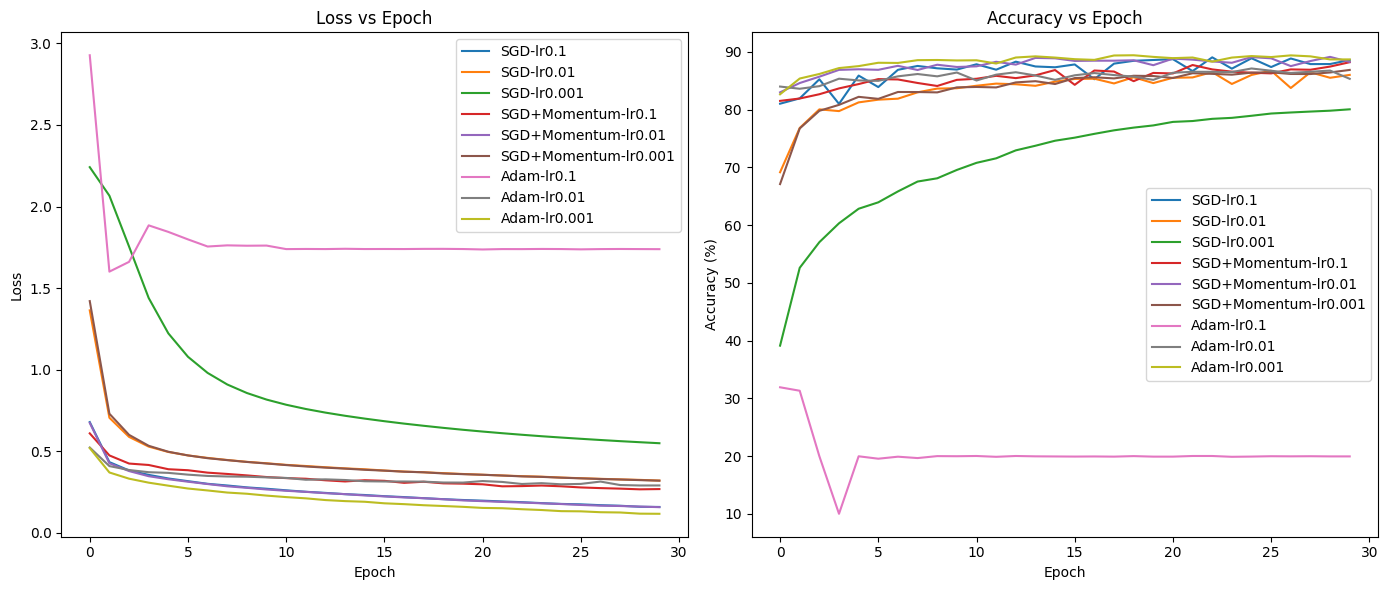

In [213]:
epochs = list(range(30))    # 에포크 수 설정
plt.figure(figsize=(14, 6))

# Loss 그래프
plt.subplot(1, 2, 1)
for label, (losses, _) in results.items():
    plt.plot(epochs, losses, label=label)
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
for label, (_, accs) in results.items():
    plt.plot(epochs, accs, label=label)
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()    # 그래프 결과 출력

<ipython-input-209-329399816e52>:11: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-209-329399816e52>:11: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-209-329399816e52>:11: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-209-329399816e52>:11: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist

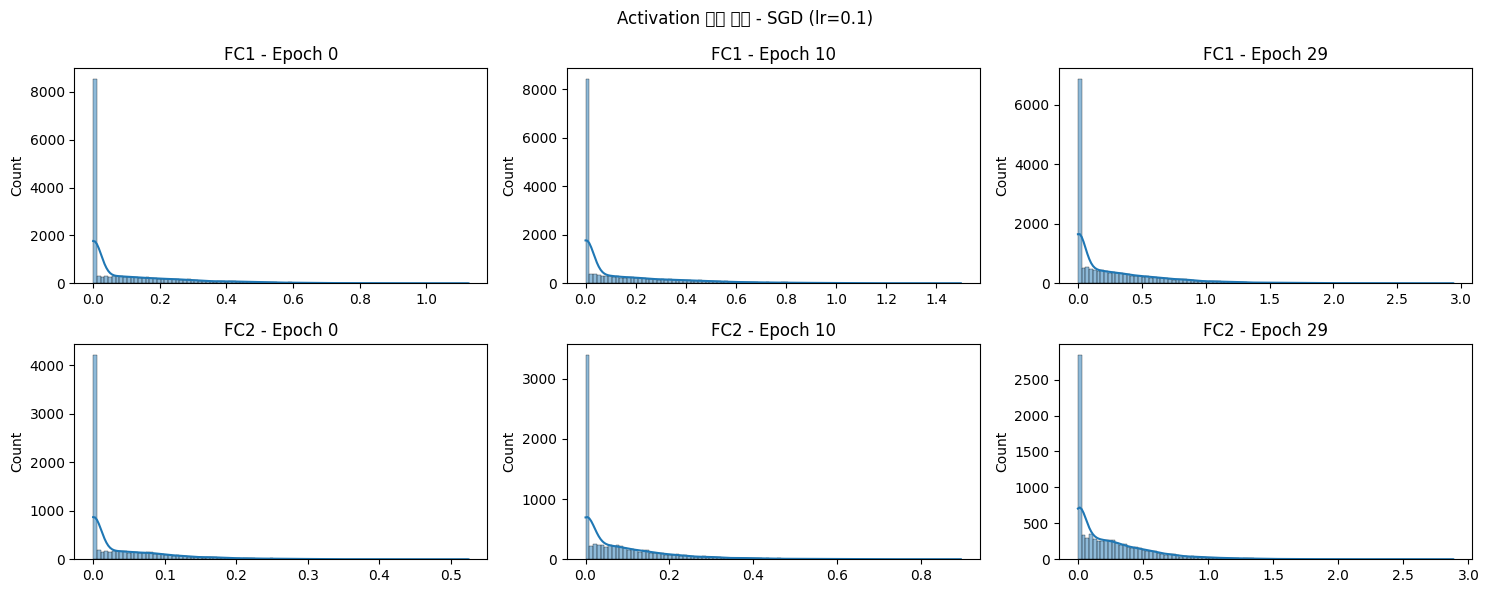

<ipython-input-209-329399816e52>:11: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-209-329399816e52>:11: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-209-329399816e52>:11: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-209-329399816e52>:11: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist

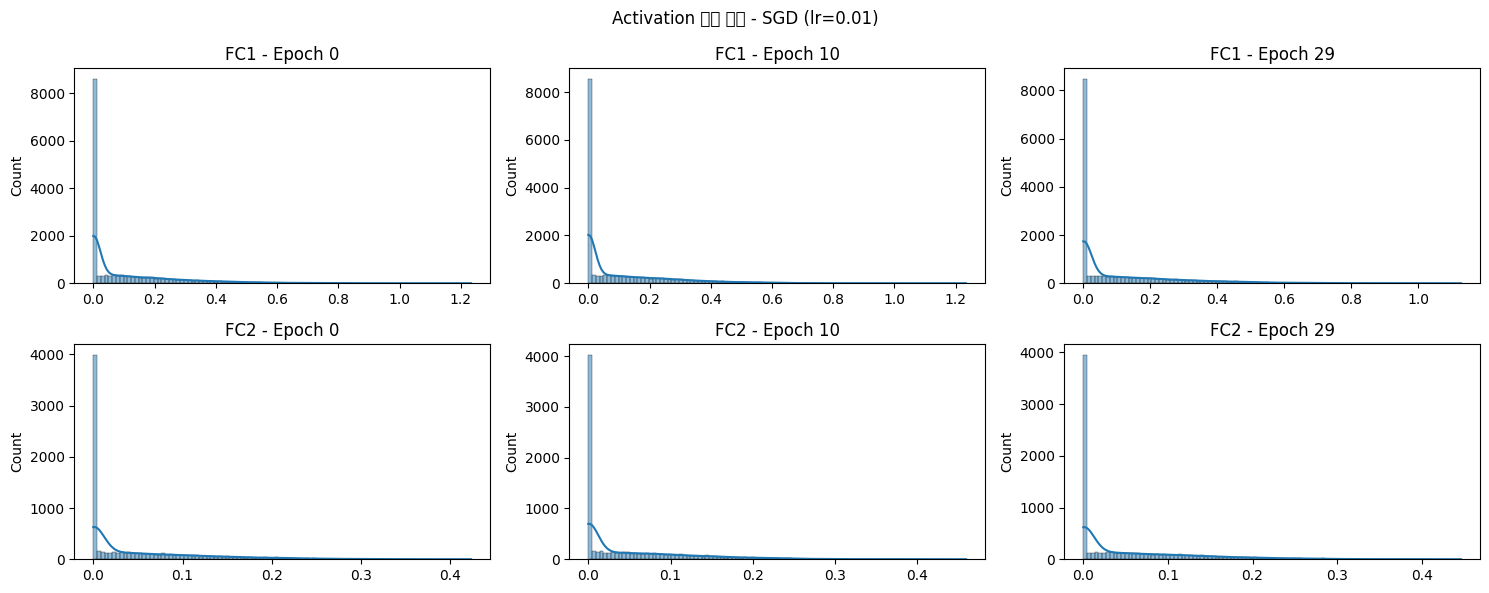

<ipython-input-209-329399816e52>:11: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-209-329399816e52>:11: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-209-329399816e52>:11: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-209-329399816e52>:11: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist

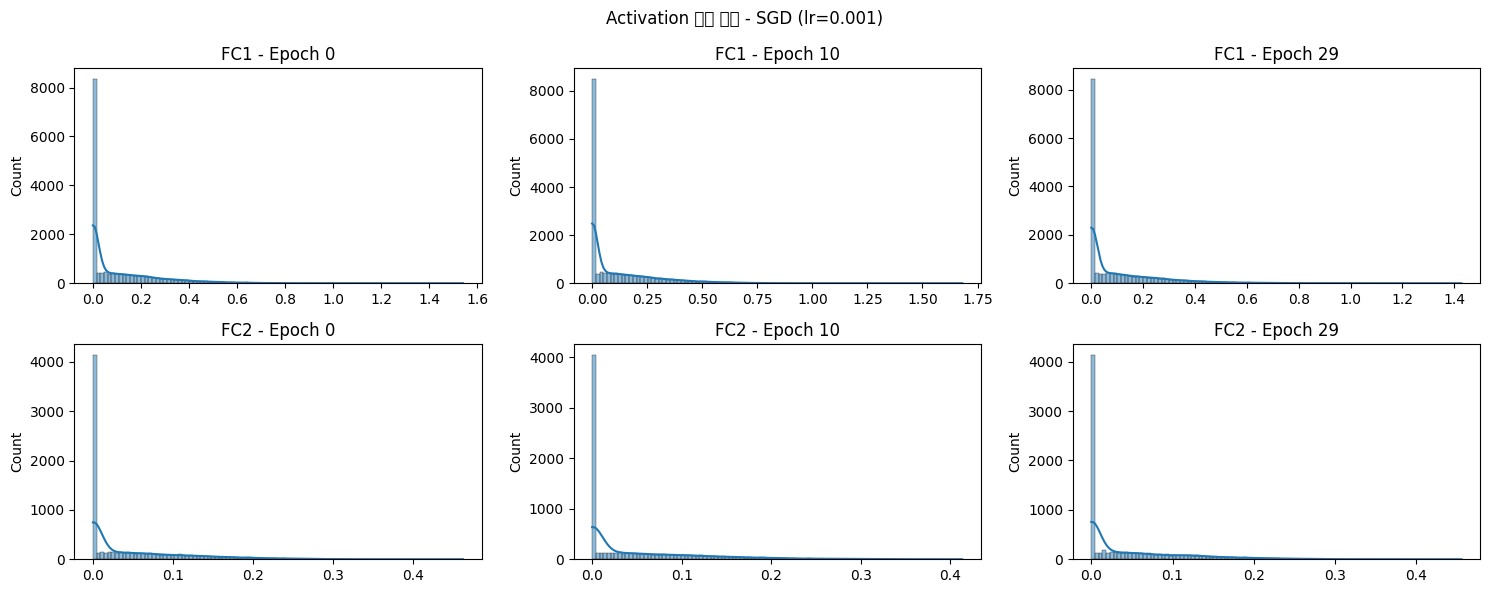

<ipython-input-209-329399816e52>:11: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-209-329399816e52>:11: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-209-329399816e52>:11: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-209-329399816e52>:11: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist

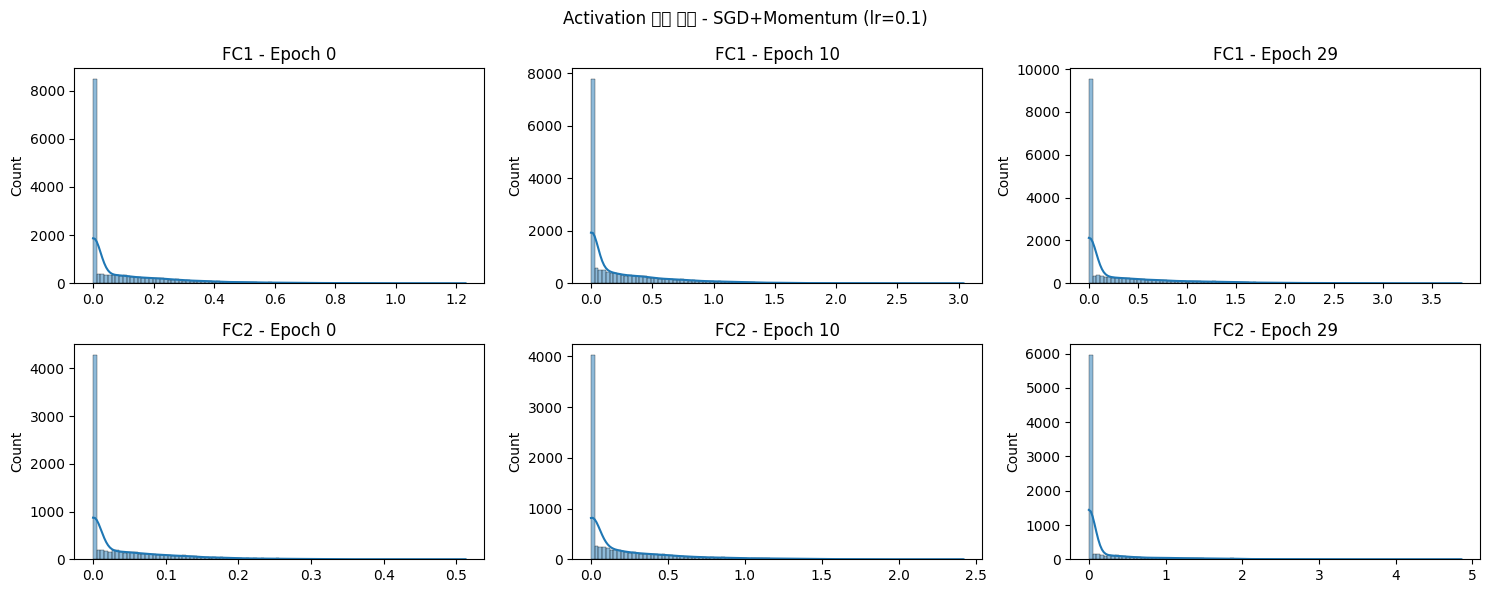

<ipython-input-209-329399816e52>:11: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-209-329399816e52>:11: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-209-329399816e52>:11: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-209-329399816e52>:11: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist

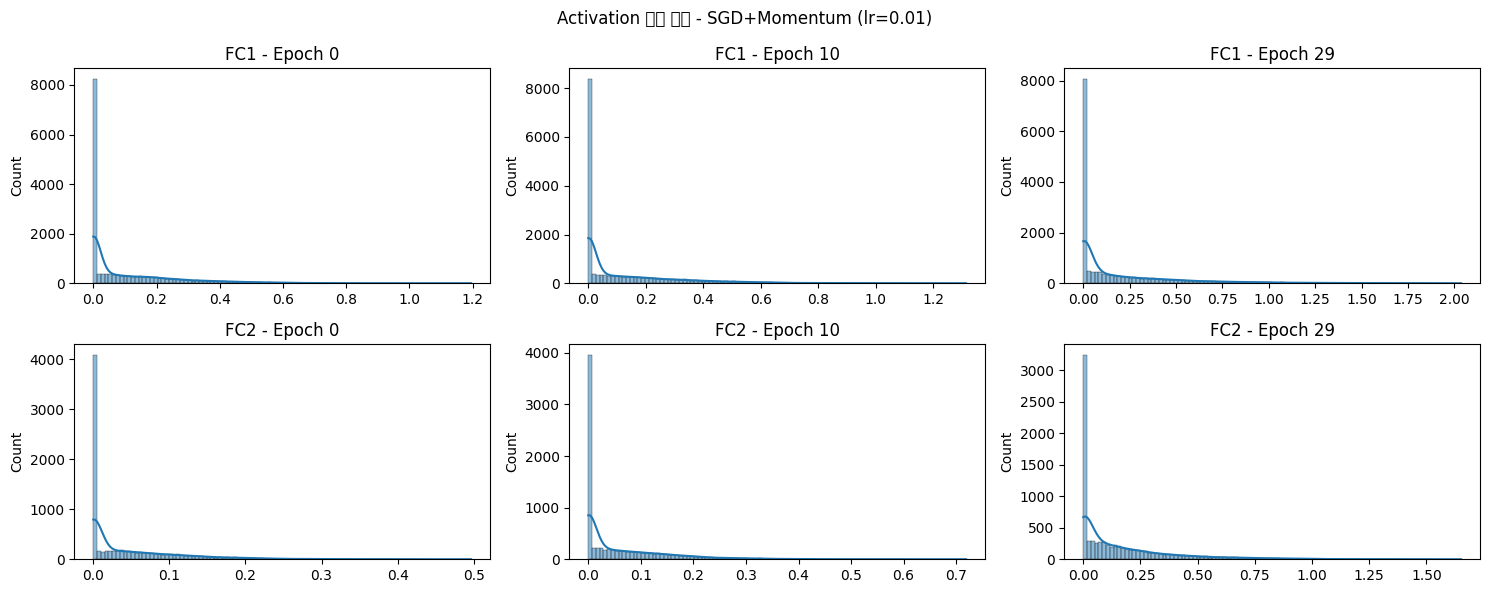

<ipython-input-209-329399816e52>:11: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-209-329399816e52>:11: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-209-329399816e52>:11: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-209-329399816e52>:11: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist

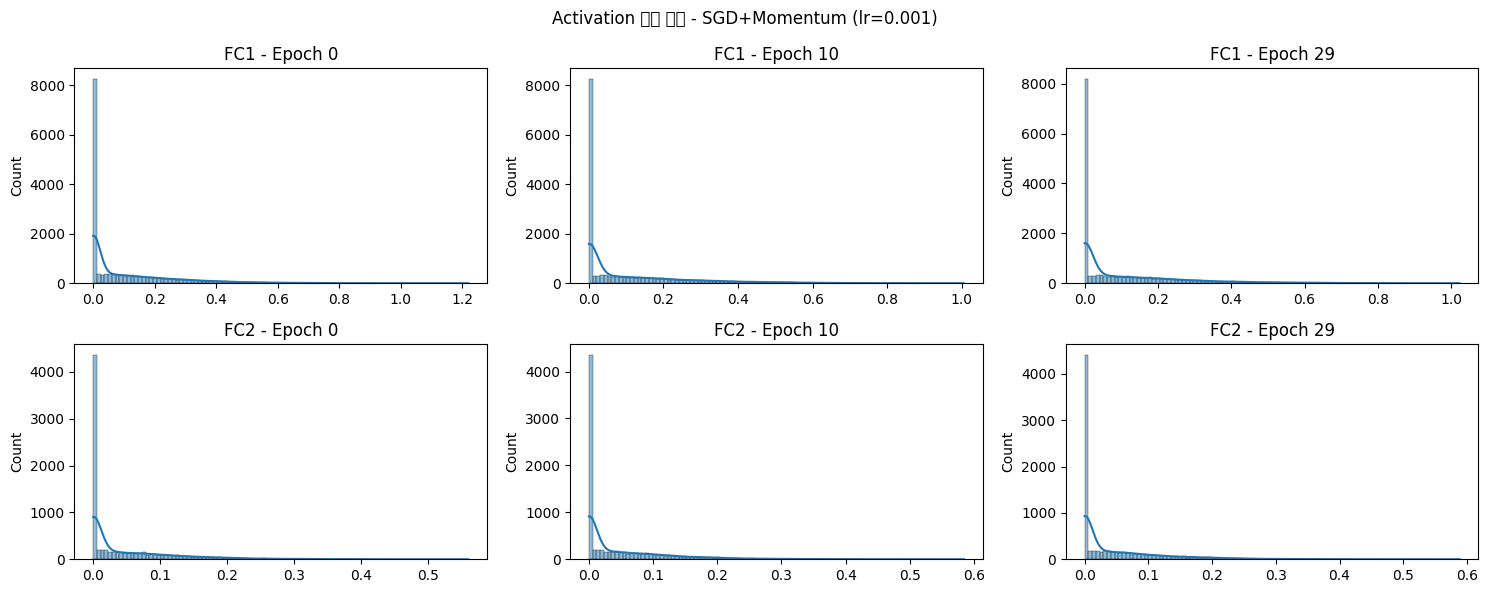

<ipython-input-209-329399816e52>:11: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-209-329399816e52>:11: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-209-329399816e52>:11: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-209-329399816e52>:11: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist

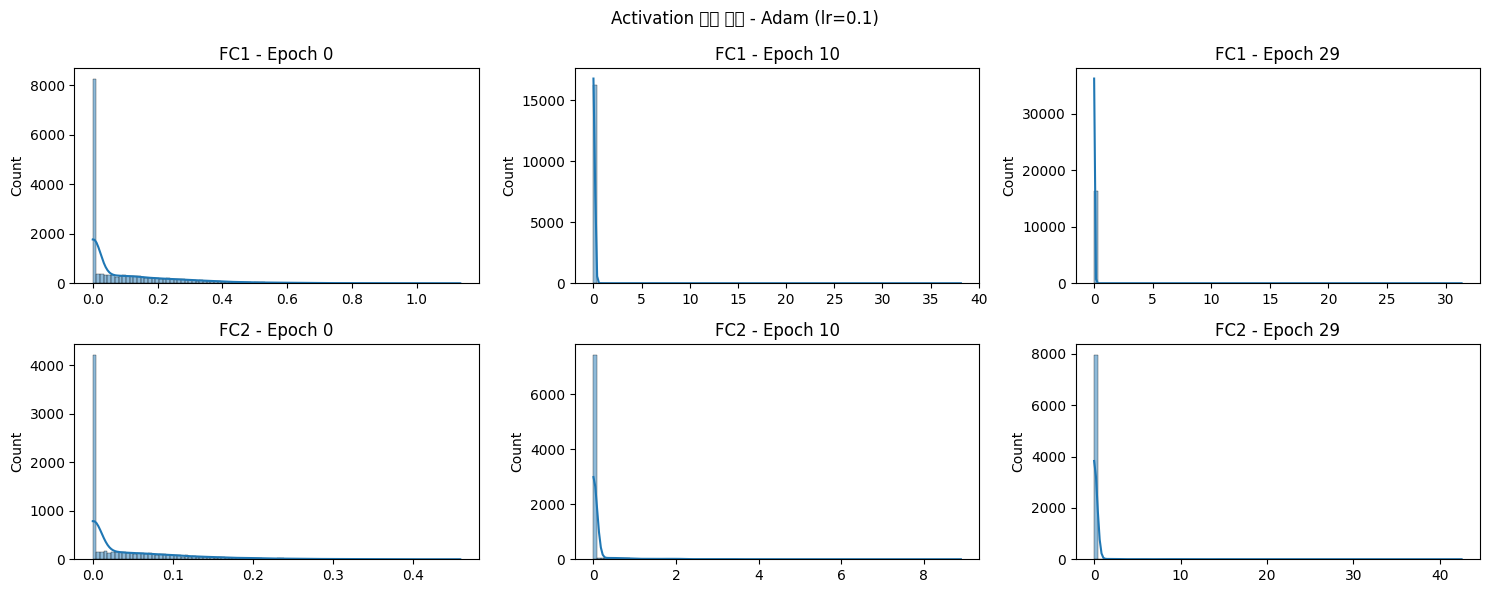

<ipython-input-209-329399816e52>:11: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-209-329399816e52>:11: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-209-329399816e52>:11: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-209-329399816e52>:11: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist

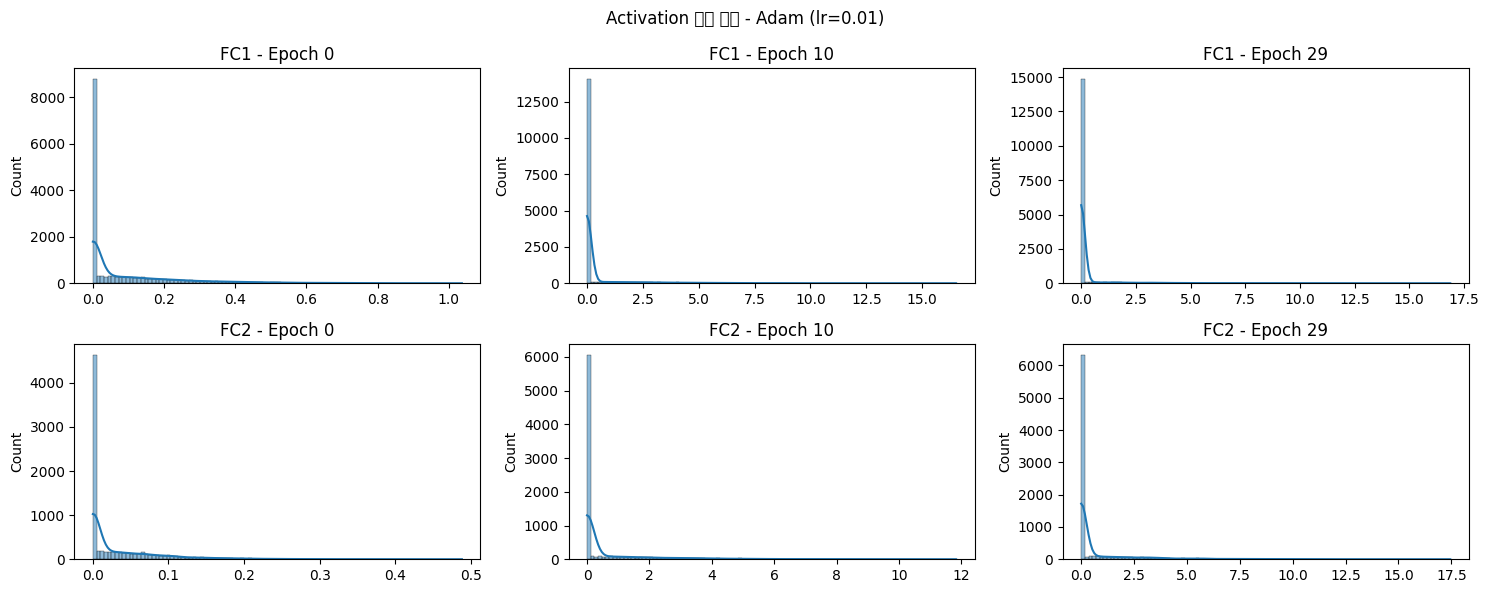

<ipython-input-209-329399816e52>:11: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-209-329399816e52>:11: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-209-329399816e52>:11: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-209-329399816e52>:11: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist

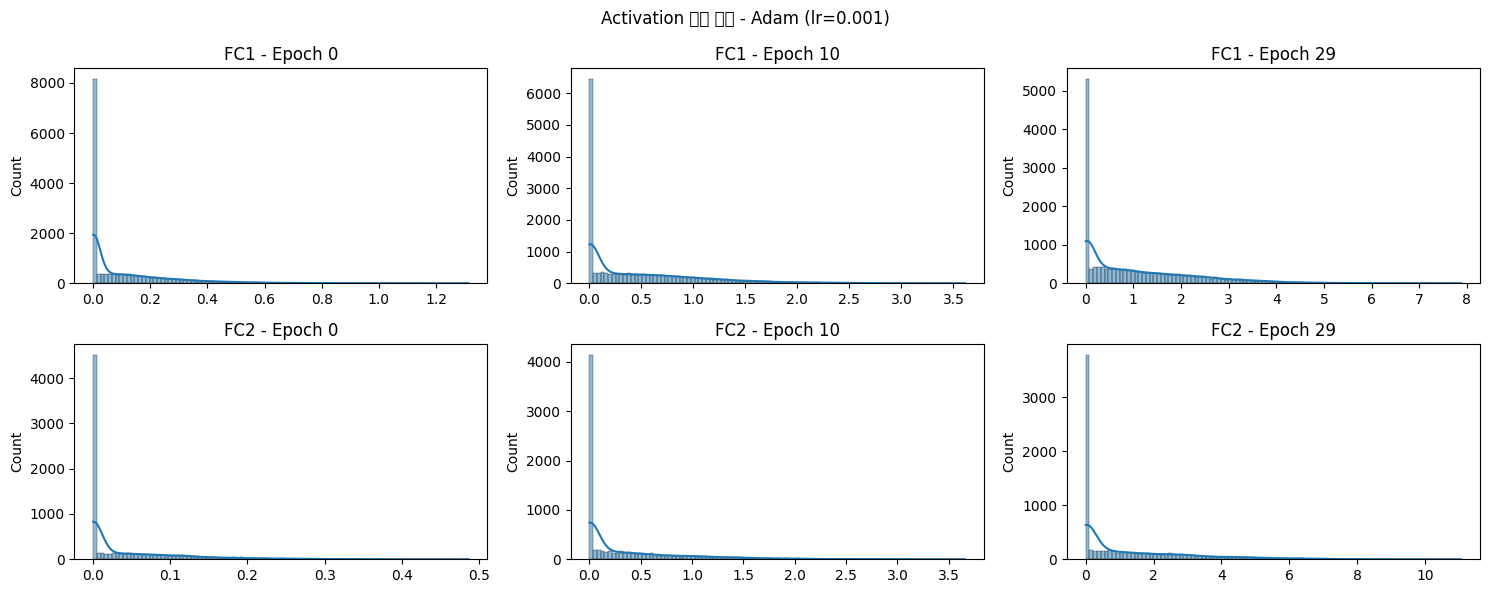

In [214]:
# Optimizer 별 학습률 조합에 대해 활성화 분포 시각화 결과 출력
compare_activation_snapshots(activation_snapshots, "SGD", 0.1)
compare_activation_snapshots(activation_snapshots, "SGD", 0.01)
compare_activation_snapshots(activation_snapshots, "SGD", 0.001)
compare_activation_snapshots(activation_snapshots, "SGD+Momentum", 0.1)
compare_activation_snapshots(activation_snapshots, "SGD+Momentum", 0.01)
compare_activation_snapshots(activation_snapshots, "SGD+Momentum", 0.001)
compare_activation_snapshots(activation_snapshots, "Adam", 0.1)
compare_activation_snapshots(activation_snapshots, "Adam", 0.01)
compare_activation_snapshots(activation_snapshots, "Adam", 0.001)